This is a time-series sales forecasting exercise. Given the limited amount of data, it is best to study all the products at the same time to create a better model.


In [557]:
#import necessary Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta,date
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

In [558]:
#read in the data
df_products = pd.read_csv('products.csv')
df_sales = pd.read_csv('cumulative_weekly_sale.csv')

In [559]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_code  83 non-null     object
 1   launch_date   83 non-null     object
 2   sale_target   83 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.1+ KB


In [560]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   end_of_week_date  769 non-null    object
 1   product_code      769 non-null    object
 2   cumulative_sale   769 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 18.1+ KB


In [561]:
print(df_products.describe())
#There are no null values, so let's see how many products we are dealing with.
print('Total # of products:',df_products['product_code'].count())

         sale_target
count      83.000000
mean    17222.891566
std     56442.840340
min       500.000000
25%      2000.000000
50%      5000.000000
75%     13500.000000
max    500000.000000
Total # of products: 83


In [562]:
print(df_sales.describe())
print('# of prodcuts already launched:',df_sales['product_code'].nunique())

       cumulative_sale
count       769.000000
mean        187.903771
std         459.170704
min           1.000000
25%           6.000000
50%          26.000000
75%         124.000000
max        3382.000000
# of prodcuts already launched: 41


In [563]:
#convert date field from string to datetime
df_products['launch_date'] = pd.to_datetime(df_products['launch_date'])
df_sales['end_of_week_date'] = pd.to_datetime(df_sales['end_of_week_date'])

In [564]:
df_products.launch_date.dtype

dtype('<M8[ns]')

In [565]:
df_sales.end_of_week_date.dtype

dtype('<M8[ns]')

Now, all columns are in the correct data types and there are no missing values. Data is ready to be analyzed. First, let's look at the prodcuts that has been already been launched. 

In [566]:
df_sales.head(10)

,end_of_week_date,product_code,cumulative_sale
0,2019-04-28,P1001,804
1,2019-04-28,P1003,26
2,2019-04-28,P1002,33
3,2019-05-05,P1001,839
4,2019-05-05,P1003,26
5,2019-05-05,P1002,33
6,2019-05-12,P1001,877
7,2019-05-12,P1003,26
8,2019-05-12,P1004,1
9,2019-05-12,P1002,43


In [569]:
df_sales_sorted = df_sales.sort_values(['product_code', 'end_of_week_date'])
df_sales_sorted.tail(100)

,end_of_week_date,product_code,cumulative_sale
538,2020-01-12,P1025,2
571,2020-01-19,P1025,2
605,2020-01-26,P1025,2
639,2020-02-02,P1025,2
676,2020-02-09,P1025,2
...,...,...,...
727,2020-02-16,P1039,1
768,2020-02-23,P1039,1
716,2020-02-16,P1040,1
757,2020-02-23,P1040,2


Exploratory Data Analysis

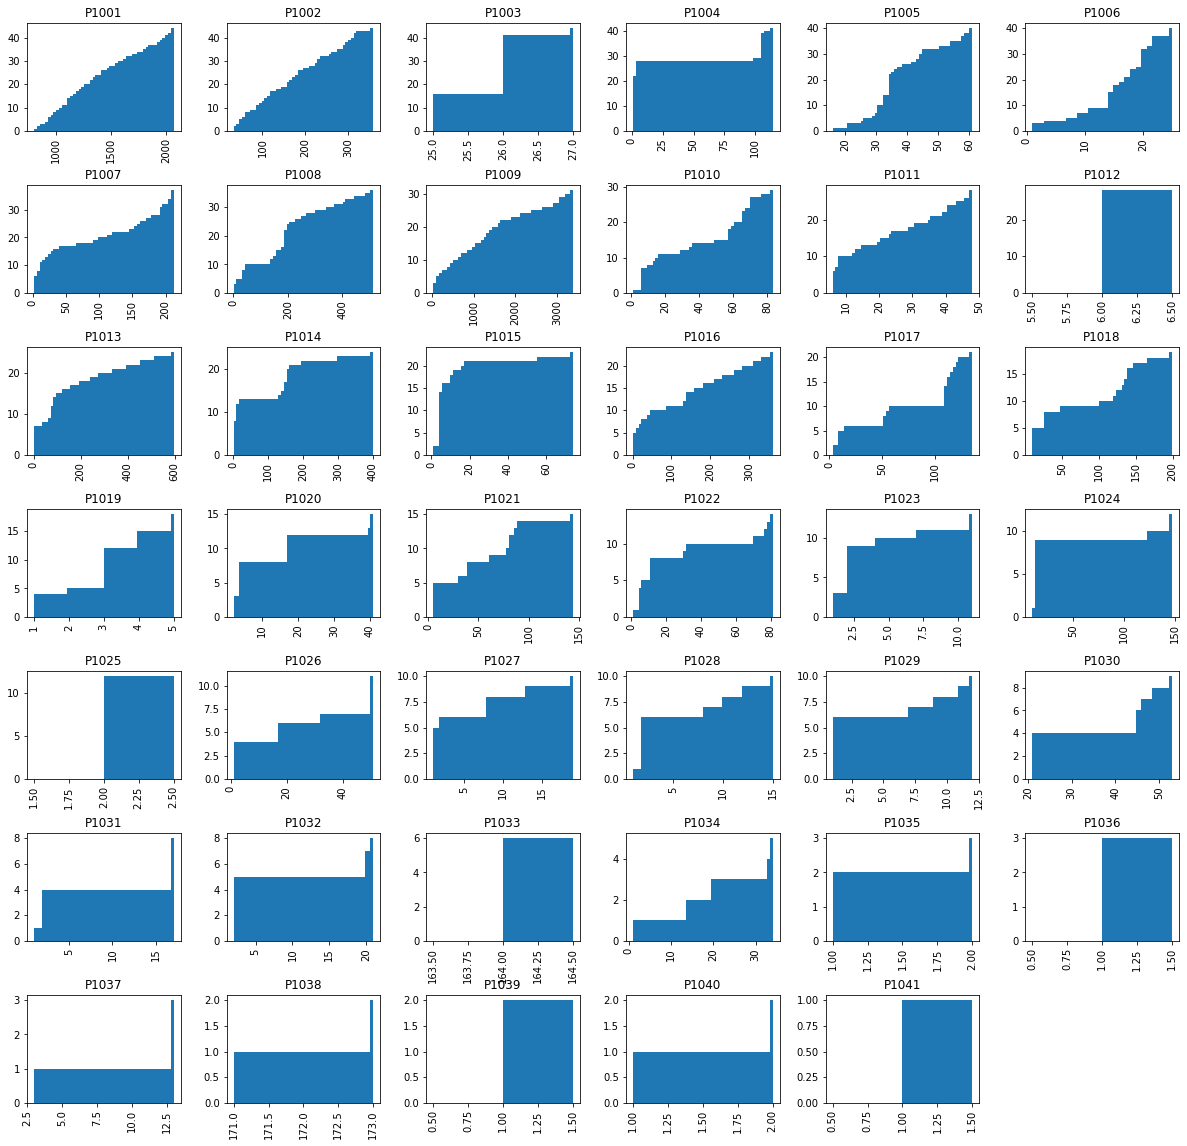

In [570]:
df_sales_sorted['cumulative_sale'].hist(by=df_sales_sorted.product_code, bins=50,figsize=(20,20),cumulative=True);


We observe that a lot of products have sold less than 100 items. Products 1009 and 1001 are the best performing products with P1009 over 3000 items sold, while the latter has sold over 2000 items. Let's visualize the target sales for each product. 

In [571]:
#Let's look at the total number of items sold for each product
max_sales=df_sales_sorted.groupby(['product_code'])['cumulative_sale'].max()
indices = np.arange(len(max_sales))
df_maxsales=pd.DataFrame(max_sales).reset_index()

In [572]:
#Let's pick the prodcuts that have already been launched:
df_products_sorted=df_products.sort_values(['product_code'])
df_launched_products=df_products_sorted.loc[indices]

#count number of weeks each product has brrn out for
duration=(df_sales_sorted.groupby(['product_code']).max()[['end_of_week_date']]-df_sales_sorted.groupby(['product_code']).min()[['end_of_week_date']])
duration=duration/np.timedelta64(1,'W')
df_duration=duration.rename(columns={'end_of_week_date':'duration_in_weeks'}).reset_index()

launched_products_concat=pd.concat([df_maxsales, df_launched_products,df_duration], axis=1)
launched_products_concat=launched_products_concat.loc[:,~launched_products_concat.columns.duplicated()]
launched_products_concat=launched_products_concat.rename(columns={'cumulative_sale':'total_sold'})
print(launched_products_concat)


   product_code  total_sold launch_date  sale_target  duration_in_weeks
0         P1001        2066  2019-04-28         5000               43.0
1         P1002         358  2019-04-28         8000               43.0
2         P1003          27  2019-04-28         1000               43.0
3         P1004         114  2019-05-12         5000               41.0
4         P1005          61  2019-05-26         2000               39.0
5         P1006          25  2019-05-26         2000               39.0
6         P1007         212  2019-06-16        15000               36.0
7         P1008         513  2019-06-23        30000               35.0
8         P1009        3382  2019-07-28        60000               30.0
9         P1010          83  2019-08-11         2000               28.0
10        P1011          48  2019-08-18         5000               27.0
11        P1012           6  2019-08-18         2000               27.0
12        P1013         595  2019-09-08        15000            

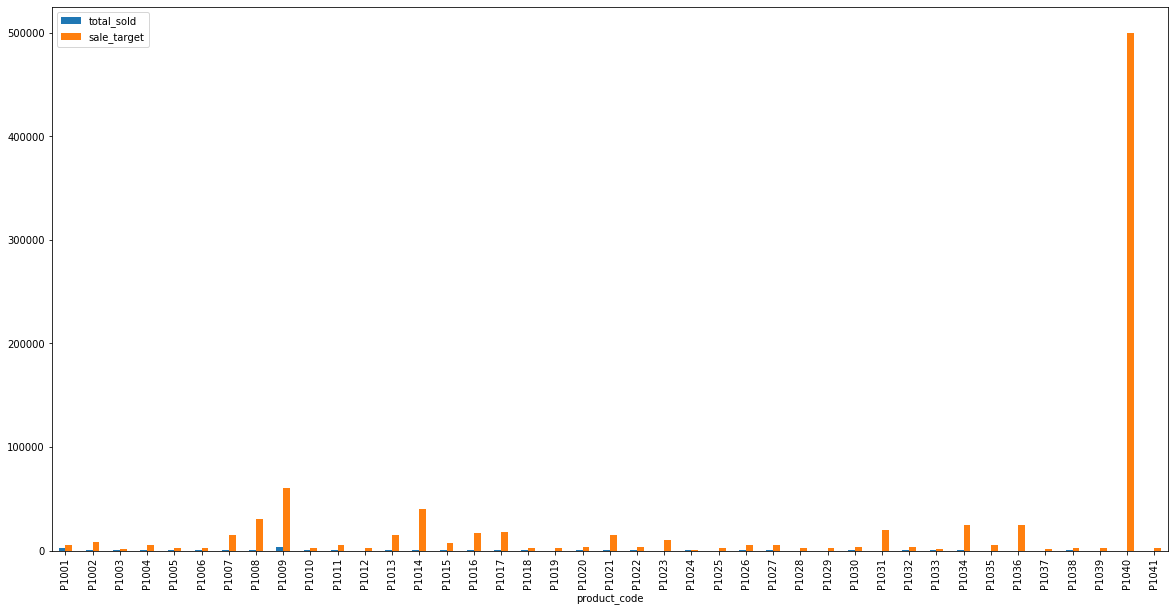

In [573]:
launched_products_concat.plot(x="product_code", y=["total_sold","sale_target"], kind="bar",figsize=(20,10));


We can conclude that none of the products have exceeded the sales target so far. 

Now, let's try to forecast sales to identify the worst-performing/slow-moving products. 


In [574]:
#calculate lowest performing products
#for code in launched_products_concat.product_code:
product_codes_list=launched_products_concat.product_code.tolist()
duration_list=launched_products_concat.duration_in_weeks.tolist()
percentage=[]
for index,row in launched_products_concat.iterrows():
        value=(row.sale_target-row.total_sold)*100.0/row.sale_target
        percentage.append(value)
#    print(row.product_code,value)

#zip product code and percentage for each and convert to list, then sort
zipped = list(zip(product_codes_list,percentage,duration_list))
product_sold_frac = sorted(zipped, key = lambda x: x[1])
print('Note: Amount of product that need to be sold to reach target and the time it has been launched for:')
print(product_sold_frac,'\n')

Note: Amount of product that need to be sold to reach target and the time it has been launched for:
[('P1001', 58.68, 43.0), ('P1024', 70.6, 11.0), ('P1033', 83.6, 5.0), ('P1018', 90.05, 19.0), ('P1038', 91.35, 1.0), ('P1009', 94.36333333333333, 30.0), ('P1002', 95.525, 43.0), ('P1010', 95.85, 28.0), ('P1013', 96.03333333333333, 24.0), ('P1005', 96.95, 39.0), ('P1003', 97.3, 43.0), ('P1022', 97.3, 13.0), ('P1004', 97.72, 41.0), ('P1016', 97.87647058823529, 22.0), ('P1030', 98.23333333333333, 8.0), ('P1008', 98.29, 35.0), ('P1007', 98.58666666666667, 36.0), ('P1020', 98.63333333333334, 16.0), ('P1037', 98.7, 2.0), ('P1006', 98.75, 39.0), ('P1015', 98.94285714285714, 22.0), ('P1026', 98.98, 10.0), ('P1014', 98.9975, 23.0), ('P1011', 99.04, 27.0), ('P1021', 99.04, 14.0), ('P1017', 99.25, 20.0), ('P1028', 99.25, 9.0), ('P1032', 99.3, 7.0), ('P1029', 99.4, 9.0), ('P1027', 99.62, 9.0), ('P1012', 99.7, 27.0), ('P1019', 99.75, 17.0), ('P1034', 99.864, 4.0), ('P1023', 99.89, 12.0), ('P1025', 99

Therefore, we can see that for prodcuts that have been launched for over 20 weeks, the top 5 performing products, respectively, with respect to their target sales values are:
P1001, P1009, P1002, P1010, P1013
and similarly, the worst performing products are:
P1012, P1017, P1011, P1014, P1015

All the other poor performing products have been only out for a couple of weeks. It is particularly interesting that P1024 has sold over 30% of it's target sales in just over 11 weeks. Furthermore, we can observe that product P1040 has a hefty target of 500000 with just 2 sold, but in one week. Let's predict how these prodcuts are going to perform in the next few weeks. 

In [575]:
#First, let's check the general trend of products:
#Feature engineering: season, product_duration, code//train test//linear regression, random forest, arima

df_sales_diff=df_sales.sort_values(['end_of_week_date'])
#sales during the past week
df_sales_diff['sales_during_past_week']=df_sales_diff.groupby(['product_code'])['cumulative_sale'].diff().fillna(value=df_sales_diff.cumulative_sale).astype(int)
#difference between the amount of sales in the previous week and the week before it (T1-T2)
df_sales_diff['last_week_diff'] = df_sales_diff.groupby(['product_code'])['sales_during_past_week'].diff()
df_sales_diff=df_sales_diff.dropna()
df_sales_diff.head(10)

,end_of_week_date,product_code,cumulative_sale,sales_during_past_week,last_week_diff
3,2019-05-05,P1001,839,35,-769.0
4,2019-05-05,P1003,26,0,-26.0
5,2019-05-05,P1002,33,0,-33.0
6,2019-05-12,P1001,877,38,3.0
7,2019-05-12,P1003,26,0,0.0
9,2019-05-12,P1002,43,10,10.0
12,2019-05-19,P1002,47,4,-6.0
10,2019-05-19,P1001,919,42,4.0
11,2019-05-19,P1003,26,0,0.0
13,2019-05-26,P1001,937,18,-24.0


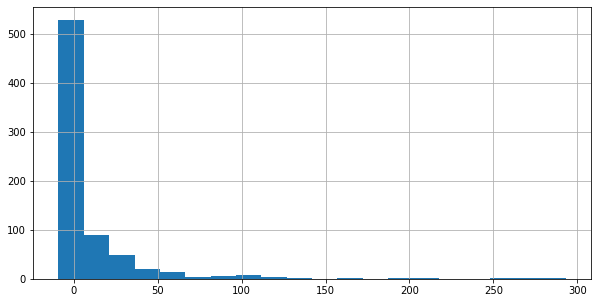

In [576]:
df_sales_diff['sales_during_past_week'].hist(bins=20, figsize=(10,5));

We see that in a given week, many products sell less than 50, while some weeks have sold over 250 items. It is interesting to note that there can be negative changes in cumulative sales, probably due to customer returns. 

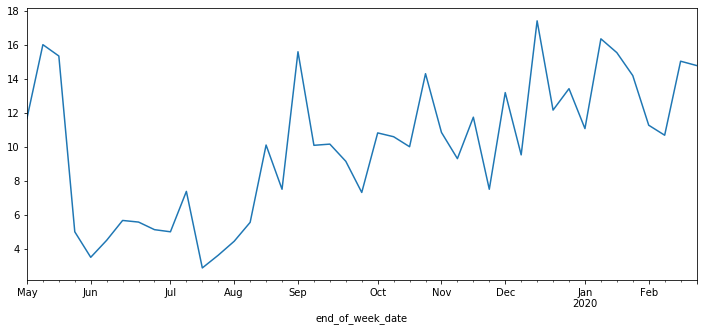

In [578]:
#seasonality check
df_sales_diff = df_sales_diff.set_index('end_of_week_date')
#Averages daily sales value for the week
y = df_sales_diff['sales_during_past_week'].resample('W').mean()
y.plot(figsize=(12,5))
plt.show()

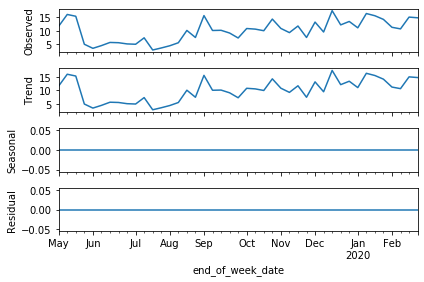

In [579]:
#time series decomposition:
#let's decompose this time series data and break down the data into the following:

from pylab import rcParams
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y, freq=1 ,model='additive')
fig = decomposition.plot()
plt.show()

It is hard to say from the above graphics whether this time series is stationary or not. Let's do a more in-depth analysis.

In [580]:
#Dickey-Fuller test function:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

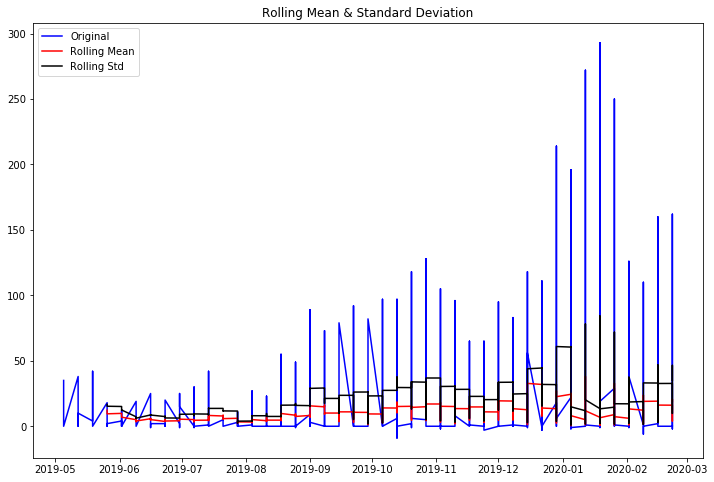

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                 -26.977110
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    727.000000
Critical Value (1%)             -3.439377
Critical Value (5%)             -2.865524
Critical Value (10%)            -2.568891
dtype: float64


In [581]:
test_stationarity(df_sales_diff['sales_during_past_week'])

The p-value is 0.00, which is less than the critical value. Thus, this series is very likely to be stationary.

#Seasonal ARIMA:

An ARIMA model is characterized by 3 terms: p, d, q where these three parameters account for seasonality (p), trend (d), and noise in data (q):

p is the order of the AR term (number of lags of Y to be used as predictors). If it snowed for the last wee, it is likely it will snow tomorrow.
q is the order of the MA term (moving average).
d is the number of differencing required to make the time series stationary. if already stationary d=0.
But when dealing with SEASONALITY, it is best to incorporate it as 's'. ARIMA(p,d,q)(P,D,Q)s. Where 'pdq' are non seasonal params and 's' is the perdiocity of the time series. 4:quarter, 12:yearly etc.

In [582]:
#perform grid search for hyper-paramter tuning:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [583]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:320.8719984304535
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1333.9104287493583
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:192.4094279862038
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:201.4267322625376
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:187.97095079023524
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:116.72783703803135
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:283.9528566424999
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1330.3891467145324
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:181.056594148273
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:198.78646724731064
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:178.58536597442517
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:116.4210376134838
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:223.86861521149646
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1111.4330654038617
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:187.43450992282519
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:163.81804581007458
SARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:161.0727472204502
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1

Therefore, the best parameters are: SARIMA(1, 1, 0)x(1, 1, 0, 12)12 with an AIC value of 96.9390053473763

In [585]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1168      0.321     -0.364      0.716      -0.746       0.513
ma.L1         -1.0000   1540.257     -0.001      0.999   -3019.849    3017.849
ar.S.L12      -0.3927      0.095     -4.137      0.000      -0.579      -0.207
sigma2         9.6715   1.49e+04      0.001      0.999   -2.92e+04    2.92e+04


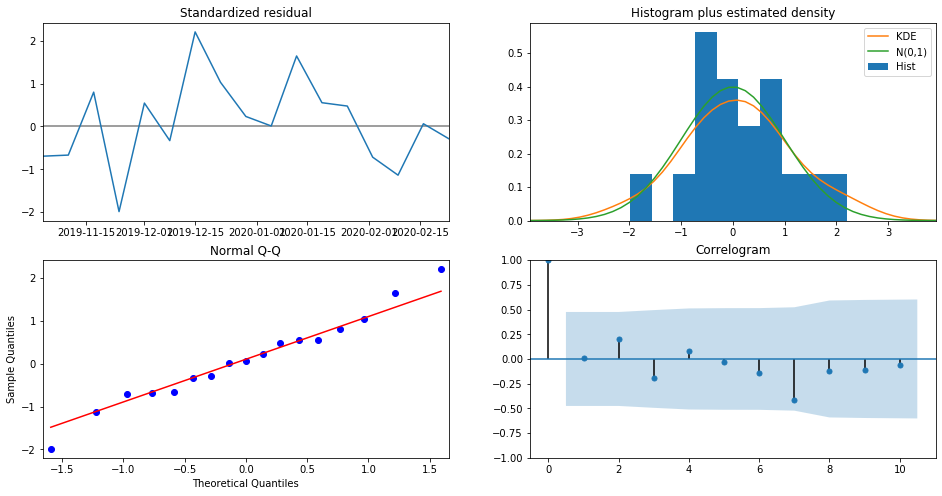

In [587]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

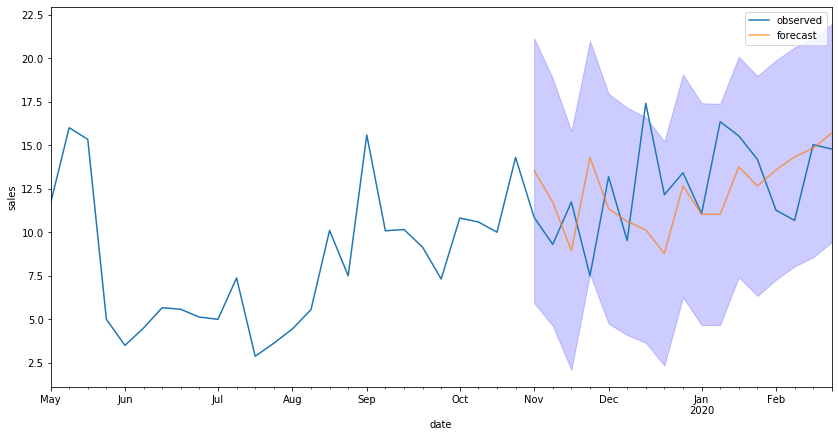

In [588]:
#model validation:

pred = results.get_prediction(start=pd.to_datetime('2019-11-03'), dynamic=False) 
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2019-05-05':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('sales')
plt.legend()
plt.show()

In [589]:
#compute accuracy of forecasted data:

y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 3.34


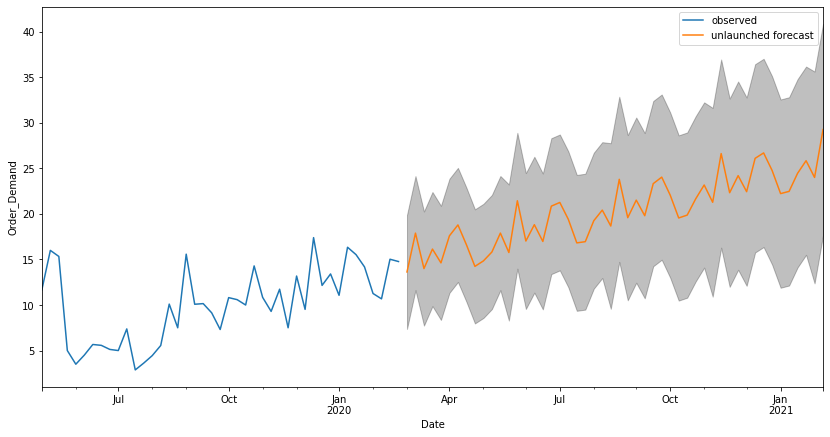

In [590]:
#For unlaunched products:

pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='unlaunched forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()



Model predicts an increase in future sales!